In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp -r /content/drive/MyDrive/rafdb /content/rafdb

In [7]:
TRAIN_DIR = "/content/drive/MyDrive/rafdb/train"
TEST_DIR  = "/content/drive/MyDrive/rafdb/test"

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report, confusion_matrix

In [8]:
import tensorflow as tf
train_data = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=(224,224),
    batch_size=64,
    label_mode="categorical",
    shuffle=True
)

test_data = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=(224,224),
    batch_size=64,
    label_mode="categorical",
    shuffle=False
)

class_names = train_data.class_names
NUM_CLASSES = len(class_names)
class_names

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.1),
])


Found 11275 files belonging to 5 classes.
Found 2835 files belonging to 5 classes.


In [9]:
from tensorflow.keras.applications.efficientnet import preprocess_input

AUTOTUNE = tf.data.AUTOTUNE

train_data_eff = train_data.map(
    lambda x, y: (preprocess_input(data_augmentation(x)), y),
    num_parallel_calls=AUTOTUNE
)

test_data_eff = test_data.map(
    lambda x, y: (preprocess_input(x), y),
    num_parallel_calls=AUTOTUNE
)

train_data_eff = train_data_eff.prefetch(AUTOTUNE)
test_data_eff  = test_data_eff.prefetch(AUTOTUNE)

In [10]:
class_names = ['Angry', 'Happy', 'Neutral', 'Sad', 'Surprise']

In [11]:
from sklearn.utils.class_weight import compute_class_weight

# Extract all labels from tf.data.Dataset
y_train = np.concatenate([
    np.argmax(y.numpy(), axis=1)
    for _, y in train_data
])

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)

class_weights = dict(enumerate(class_weights))
class_weights

{0: np.float64(3.1895332390381896),
 1: np.float64(0.4725481978206203),
 2: np.float64(0.8934231378763867),
 3: np.float64(1.1377396569122098),
 4: np.float64(1.748062015503876)}

In [12]:
base_model = tf.keras.applications.EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)

base_model.trainable = False

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.3)(x)

outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = tf.keras.Model(inputs=base_model.input, outputs=outputs)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,383,912 (16.72 MB)

 Trainable params: 331,781 (1.27 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

In [14]:
history_head = model.fit(
    train_data_eff,
    validation_data=test_data_eff,
    epochs=10,
    class_weight=class_weights
)

Epoch 1/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 191s 896ms/step - accuracy: 0.3344 - loss: 1.8982 - val_accuracy: 0.4952 - val_loss: 1.3338
Epoch 2/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 128s 721ms/step - accuracy: 0.4586 - loss: 1.3915 - val_accuracy: 0.5563 - val_loss: 1.1574
Epoch 3/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 129s 728ms/step - accuracy: 0.5026 - loss: 1.2692 - val_accuracy: 0.5891 - val_loss: 1.0705
Epoch 4/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 130s 728ms/step - accuracy: 0.5463 - loss: 1.1714 - val_accuracy: 0.6063 - val_loss: 1.0305
Epoch 5/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 129s 725ms/step - accuracy: 0.5591 - loss: 1.1091 - val_accuracy: 0.6303 - val_loss: 0.9912
Epoch 6/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 130s 733ms/step - accuracy: 0.5788 - loss: 1.0518 - val_accuracy: 0.6367 - val_loss: 0.9608
Epoch 7/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 133s 747ms/step - accuracy: 0.5936 - loss: 1.0248 - val_accuracy: 0.6406 - val_loss: 0.9550
Epoch 8/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 131s 738ms/step - accuracy: 0.6094 -

In [16]:
for layer in base_model.layers[-20:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=4,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        "/content/drive/MyDrive/efficientnet_best_new.keras",
        monitor="val_loss",
        save_best_only=True
    )
]

history_fine = model.fit(
    train_data_eff,
    validation_data=test_data_eff,
    epochs=20,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 180s 857ms/step - accuracy: 0.6554 - loss: 0.8477 - val_accuracy: 0.6864 - val_loss: 0.8486
Epoch 2/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 132s 743ms/step - accuracy: 0.6651 - loss: 0.8063 - val_accuracy: 0.6903 - val_loss: 0.8380
Epoch 3/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 131s 735ms/step - accuracy: 0.6761 - loss: 0.7977 - val_accuracy: 0.6952 - val_loss: 0.8257
Epoch 4/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 132s 742ms/step - accuracy: 0.6820 - loss: 0.7778 - val_accuracy: 0.6966 - val_loss: 0.8180
Epoch 5/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 141s 737ms/step - accuracy: 0.6931 - loss: 0.7651 - val_accuracy: 0.7005 - val_loss: 0.8103
Epoch 6/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 131s 735ms/step - accuracy: 0.6849 - loss: 0.7784 - val_accuracy: 0.7086 - val_loss: 0.7983
Epoch 7/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 131s 738ms/step - accuracy: 0.6902 - loss: 0.7401 - val_accuracy: 0.7090 - val_loss: 0.7895
Epoch 8/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 130s 727ms/step - accuracy: 0.6965 -

In [21]:
from tensorflow.keras.models import load_model

model = load_model("/content/drive/MyDrive/efficientnet_best_new.keras")

In [22]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model = tf.keras.models.load_model("/content/drive/MyDrive/efficientnet_best_new.keras")

y_true, y_pred = [], []

for x, y in test_data_eff:
    preds = model.predict(x)
    y_true.extend(np.argmax(y.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

print(classification_report(y_true, y_pred, target_names=class_names))

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
2/2 

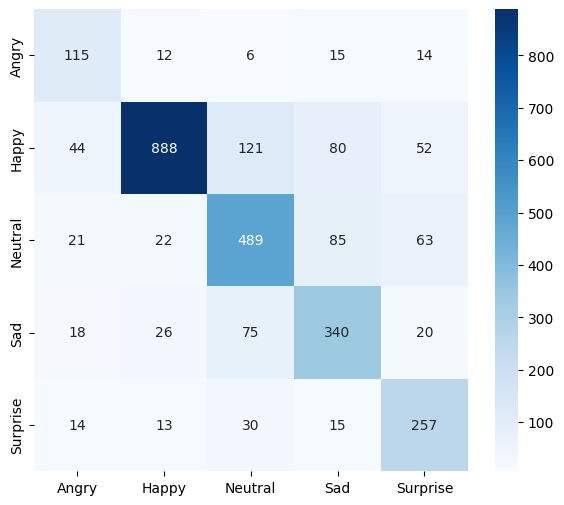

In [19]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_names,
            yticklabels=class_names,
            cmap="Blues")
plt.show()